<a href="https://colab.research.google.com/github/ABRD123/anamoly-detection/blob/main/BICC%2BLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Data Loading and Normalisation

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy.signal import butter, lfilter

# Constants
DATA_DIR = "/content/drive/MyDrive/AnomalyDatasets_2021/UCR_TimeSeriesAnomalyDatasets2021/FilesAreInHere/UCR_Anomaly_FullData"
SAMPLING_FREQUENCY = 64000  # Hz
FILTER_ORDER = 2  # Butterworth filter order
FREQUENCY_BANDS = [
    (16000, 32000), (8000, 16000), (4000, 8000),
    (2000, 4000), (1000, 2000), (500, 1000), (250, 500), (0, 250)
]

# Step 1: Load the Dataset
def load_raw_data(data_dir):
    """Loads all raw sensor data from files in the given directory."""
    data_frames = []
    for filename in os.listdir(data_dir):
        file_path = os.path.join(data_dir, filename)
        if os.path.isfile(file_path):
            df = pd.read_csv(file_path, sep='\t', header=None)
            data_frames.append(df)
    return pd.concat(data_frames, ignore_index=True)

# Step 2: Normalize Data
def apply_normalization(raw_data):
    """Applies MinMax scaling after handling non-numeric values."""
    processed_data = pd.DataFrame(raw_data).apply(pd.to_numeric, errors='coerce').dropna()
    return MinMaxScaler().fit_transform(processed_data)

# Step 3: Split Data into Train, Validation, and Test Sets
def split_dataset(data, test_ratio=0.2, val_ratio=0.2):
    """Splits the dataset into training, validation, and test sets."""
    X_train, temp_data = train_test_split(data, test_size=test_ratio, random_state=42)
    X_val, X_test = train_test_split(temp_data, test_size=val_ratio / (1 - test_ratio), random_state=42)
    return X_train, X_val, X_test

# Step 4: Apply Butterworth Bandpass Filter
def apply_butterworth_filter(signal, low_cut, high_cut, sampling_freq, order=FILTER_ORDER):
    """Applies a Butterworth filter to extract frequency bands."""
    nyquist_freq = sampling_freq / 2.0
    low, high = low_cut / nyquist_freq, high_cut / nyquist_freq

    if low == 0:
        b, a = butter(order, high, btype='low', analog=False)
    elif high == 1:
        b, a = butter(order, low, btype='high', analog=False)
    else:
        b, a = butter(order, [low, high], btype='band', analog=False)

    return lfilter(b, a, signal)

# Main Execution Flow
if __name__ == "__main__":
    # Load Raw Data
    raw_data = load_raw_data(DATA_DIR)
    print(f"Dataset Shape: {raw_data.shape}")
    print(raw_data.head())

    # Normalize Data
    normalized_data = apply_normalization(raw_data)

    # Split Dataset
    X_train, X_val, X_test = split_dataset(normalized_data)

    # Filtering - Apply Butterworth Filter to Extract Features
    filtered_features = {
        f"band_{low}_{high}": apply_butterworth_filter(X_train[:, 0], low, high, SAMPLING_FREQUENCY)
        for low, high in FREQUENCY_BANDS
    }

    print("Preprocessing Completed Successfully!")

Dataset Shape: (18222498, 1)
      0
0  13.3
1  12.4
2  11.6
3  11.3
4  11.5
Preprocessing Completed Successfully!


### Framing & Resampling

Framed signal shape: (14577960, 8)


/usr/local/lib/python3.11/dist-packages/matplotlib/image.py:178: UserWarning: Data with more than 2**23 columns cannot be accurately displayed. Downsampling to less than 2**23 columns before displaying. To remove this warning, manually downsample your data.
  warnings.warn(msg.format(n='2**23 columns'))


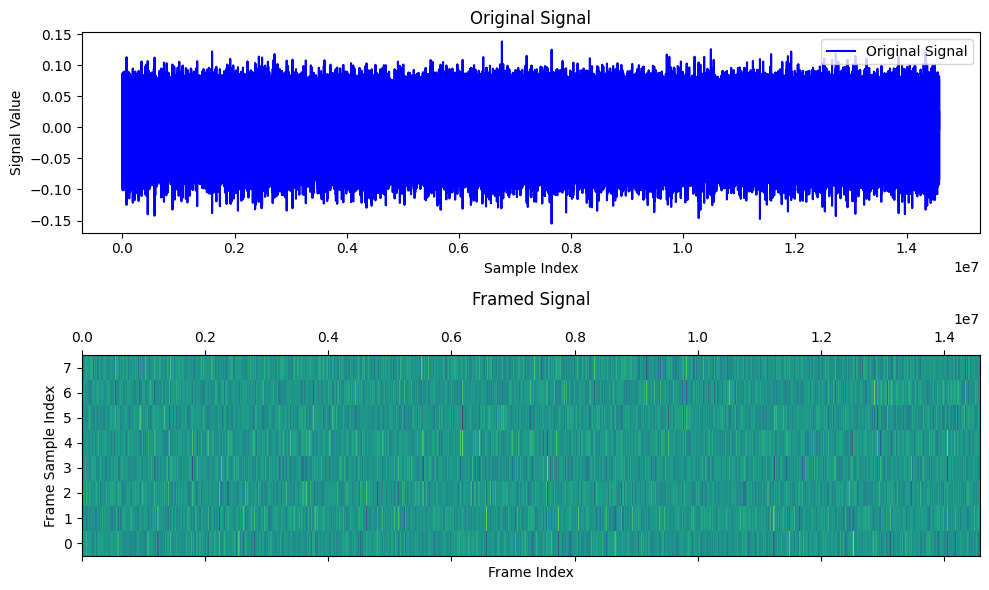

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define framing parameters
FRAME_SIZE = 8       # Number of samples per frame
SLIDING_STEP = 1     # Slide by 1 sample for each frame
SKIP_SIZE = 4        # Skip every sample within a frame
PLOT_EVERY_NTH_FRAME = 10  # Only plot every nth frame to reduce load

# Function to frame the signal using vectorized NumPy operations
def apply_framing(signal, frame_size, skip_size, sliding_step):
    """Frames the signal into overlapping segments with skip and slide."""
    num_frames = (len(signal) - frame_size * skip_size) // sliding_step + 1
    indices = np.arange(frame_size) * skip_size  # Precompute skipping indices
    starts = np.arange(0, num_frames * sliding_step, sliding_step)[:, None]
    valid_starts = starts + indices  # Generate index matrix
    valid_starts = valid_starts[valid_starts[:, -1] < len(signal)]  # Filter valid frames
    return signal[valid_starts] if len(valid_starts) > 0 else np.array([])

# Select the third-highest frequency band for framing
third_highest_band = sorted(filtered_features.keys())[-3]
band_signal = filtered_features[third_highest_band]

# Apply framing to the selected frequency band
framed_signal = apply_framing(np.array(band_signal), FRAME_SIZE, SKIP_SIZE, SLIDING_STEP)

# Print the shape of the framed signal
print(f"Framed signal shape: {framed_signal.shape}")

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(10, 6))

# Plot the original signal
ax[0].plot(band_signal, label='Original Signal', color='blue')
ax[0].set_title('Original Signal')
ax[0].set_xlabel('Sample Index')
ax[0].set_ylabel('Signal Value')
ax[0].legend(loc='upper right')

# Plot framed signal as a heatmap for efficiency
ax[1].matshow(framed_signal.T, aspect='auto', cmap='viridis', origin='lower')
ax[1].set_title('Framed Signal')
ax[1].set_xlabel('Frame Index')
ax[1].set_ylabel('Frame Sample Index')

plt.tight_layout()
plt.show()


### DWPT

In [ ]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 54.5 MB/s eta 0:00:00


Signal length exceeds or matches the maximum length. Skipping padding.
Using decomposition level: 3 (Max possible: 10)
Error: num must be an integer with 1 <= num <= 4, not 5


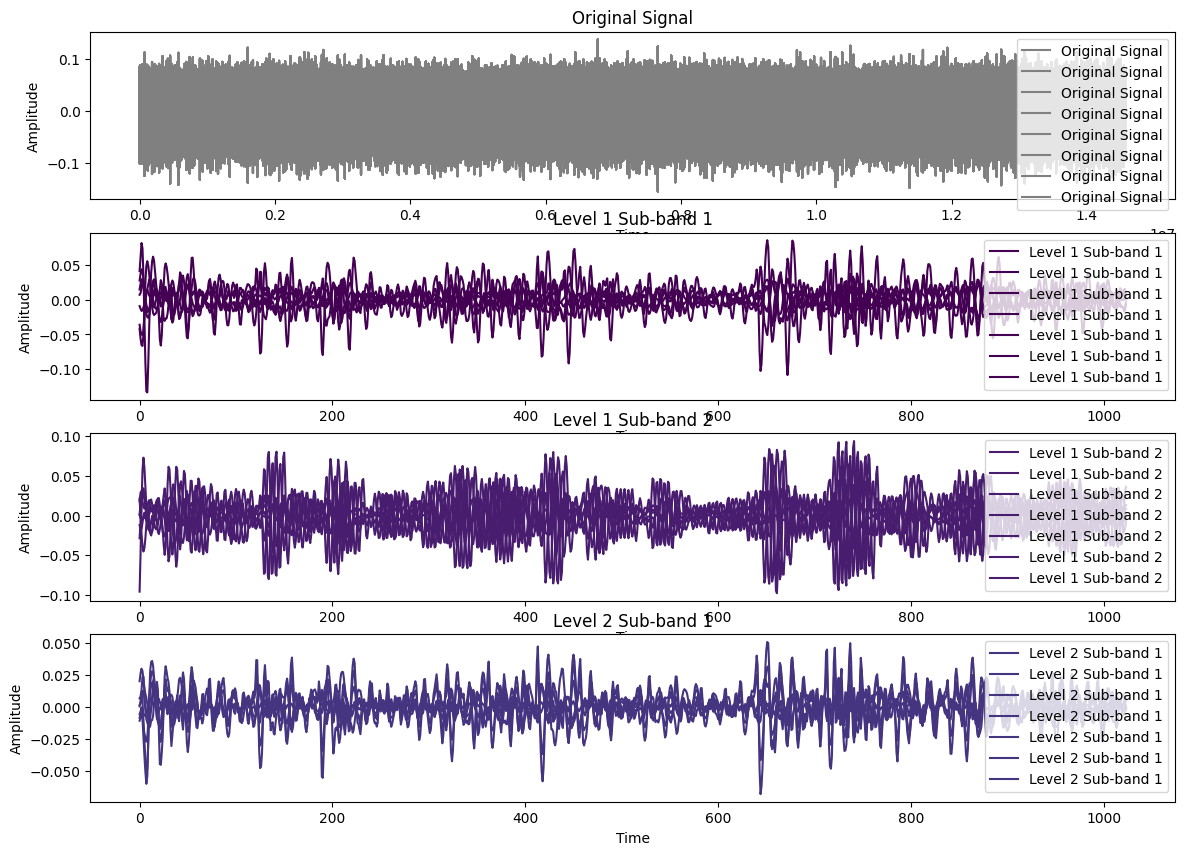

In [ ]:
import numpy as np
import pywt
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Constants for wavelet transform
WAVELET_TYPE = 'db4'
DEFAULT_MAX_LEVEL = 3
MAX_PAD_LENGTH = 1024  # Limit padding to 1024 samples

# Ensure signal length is a power of two by padding with zeros
def ensure_power_of_two(signal, max_length=MAX_PAD_LENGTH):
    """Pads the signal to the nearest power of two (up to max_length)."""
    signal_length = len(signal)

    if signal_length >= max_length:
        print("Signal length exceeds or matches the maximum length. Skipping padding.")
        return signal[:max_length]

    next_power_of_two = min(2 ** np.ceil(np.log2(signal_length)).astype(int), max_length)
    return np.pad(signal, (0, next_power_of_two - signal_length), mode='constant')

# Perform Discrete Wavelet Packet Transform (DWPT) with auto max level
def perform_dwpt(signal, wavelet=WAVELET_TYPE, max_level=DEFAULT_MAX_LEVEL):
    """Performs Wavelet Packet Decomposition and extracts wavelet coefficient vectors."""
    signal = ensure_power_of_two(signal)
    signal_length = len(signal)

    # Auto-adjust max decomposition level
    max_possible_level = int(np.log2(signal_length))
    adjusted_level = min(max_level, max_possible_level)  # Ensure valid level

    if adjusted_level < 1:
        raise ValueError(f"Signal length {signal_length} is too short for wavelet decomposition.")

    print(f"Using decomposition level: {adjusted_level} (Max possible: {max_possible_level})")

    # Perform wavelet packet decomposition
    wp = pywt.WaveletPacket(data=signal, wavelet=wavelet, mode='symmetric', maxlevel=adjusted_level)

    # Extract coefficients at each level
    wp_coeffs = {level: [node.data for node in wp.get_level(level, 'freq')] for level in range(1, adjusted_level + 1)}

    return wp_coeffs

# Visualize the Wavelet Packet Decomposition
def visualize_dwpt(wp_coeffs, signal, title="Wavelet Packet Decomposition"):
    """Plots the wavelet packet decomposition levels and coefficients."""
    num_levels = len(wp_coeffs)
    color_cycle = cm.viridis(np.linspace(0, 1, sum(len(coeffs) for coeffs in wp_coeffs.values())))

    plt.figure(figsize=(14, 10))

    # Plot original signal
    plt.subplot(num_levels + 1, 1, 1)
    plt.plot(signal, label="Original Signal", color='gray')
    plt.title("Original Signal")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.legend(loc='upper right')

    # Plot each coefficient set at each level
    band_idx = 0
    for level, coeffs in wp_coeffs.items():
        for idx, coeff in enumerate(coeffs):
            plt.subplot(num_levels + 1, 1, band_idx + 2)
            plt.plot(coeff, label=f"Level {level} Sub-band {idx + 1}", color=color_cycle[band_idx])
            plt.title(f"Level {level} Sub-band {idx + 1}")
            plt.xlabel("Time")
            plt.ylabel("Amplitude")
            plt.legend(loc='upper right')
            band_idx += 1

    plt.tight_layout()
    plt.show()

# Perform decomposition and plot
try:
    wavelet_coeffs = perform_dwpt(framed_signal, WAVELET_TYPE, DEFAULT_MAX_LEVEL)
    visualize_dwpt(wavelet_coeffs, framed_signal)
except ValueError as e:
    print(f"Error: {e}")

### BICC

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from tensorflow.keras.utils import pad_sequences
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, precision_score, recall_score

class SpineNode:
    """ Represents a temporary spine that may mature into a cortical node. """
    def __init__(self, value):
        self.value = np.asarray(value, dtype=np.float32).flatten()
        self.maturity_level = 0  # Tracks reinforcement count

class CorticalNode:
    """ Represents a cortical node that generalizes features. """
    def __init__(self, value, progeny_nodes=None):
        self.value = np.asarray(value, dtype=np.float32).flatten()
        self.progeny_nodes = progeny_nodes or []
        self.spines = []  # Track associated spines

    def update(self, coefficient, learning_rate=0.5):
        """ Update node's value using a weighted update rule. """
        self.value = (1 - learning_rate) * self.value + learning_rate * coefficient

class CorticalCodingNetwork:
    """ Implements a cortical coding-based feature extraction model. """
    def __init__(self, input_size=8, max_nodes=10000):
        self.input_size = input_size
        self.max_nodes = max_nodes  # Cap number of nodes to avoid overfitting
        self.nodes = []  # List of cortical nodes
        self.spines = []  # List of spine nodes
        self.tree = None  # KDTree for fast lookup
        self.reconstruction_errors = []  # Store reconstruction errors for analysis
        self.thresholds = []  # Store thresholds for threshold selection plot

    def build_kdtree(self):
        """ Build a KDTree for fast nearest neighbor search of nodes. """
        node_values = np.array([node.value for node in self.nodes])
        if node_values.ndim == 1:
            node_values = node_values.reshape(-1, 1)
        self.tree = KDTree(node_values)

    def find_closest(self, target, elements):
        """ Find the closest element to the target. """
        if not elements:
            return None, float('inf')  # No elements to compare against.

        # Convert target into a numpy array
        target = np.asarray(target, dtype=np.float32).reshape(1, -1)

        # Convert each element into a numpy array
        values = np.vstack([np.asarray(e.value, dtype=np.float32).reshape(1, -1) for e in elements])

        # Compute distances
        distances = np.linalg.norm(values - target, axis=1)

        min_index = np.argmin(distances)
        min_distance = distances[min_index]

        return elements[min_index], min_distance

    def update_element(self, element, coefficient, learning_rate=0.5):
        """ Generalized update function for nodes and spines with L2 regularization. """
        regularization_term = 0.001 * np.linalg.norm(element.value)  # L2 regularization term
        element.value = (1 - learning_rate) * element.value + learning_rate * coefficient - regularization_term

    def evolve_spine_to_node(self, spine):
        """ Convert a mature spine into a cortical node. """
        new_node = CorticalNode(spine.value)
        self.nodes.append(new_node)

        # Prune nodes if the number exceeds max_nodes
        if len(self.nodes) > self.max_nodes:
            self.prune_nodes()

        self.spines.remove(spine)
        return new_node

    def generate_spine(self, coefficient):
        """ Create a new spine node with added noise for diversity. """
        noise = np.random.normal(0, 0.01, size=coefficient.shape)
        new_spine = SpineNode(coefficient + noise)
        self.spines.append(new_spine)
        return new_spine

    def extract_features(self, coefficient_array):
        """ Extract relevant statistical features. """
        coefficient_array = np.asarray(coefficient_array)
        return [
            np.mean(coefficient_array),
            np.var(coefficient_array),
            np.sum(coefficient_array ** 2)  # Energy
        ]

    def reconstruct(self, X):
        """ Reconstruct input using closest cortical nodes (optimized). """
        if not self.nodes:
            return np.zeros_like(X)

        # Rebuild KDTree when nodes are updated
        self.build_kdtree()

        # Find nearest neighbor indices for all X points
        _, indices = self.tree.query(X, k=1)  # Get closest node index

        node_values = np.array([node.value for node in self.nodes])
        return node_values[indices]

    def calculate_reconstruction_error(self, X, reconstructed_X):
        """ Calculate reconstruction error for a set of samples. """
        error = np.linalg.norm(X - reconstructed_X, axis=1)
        self.reconstruction_errors.extend(error)
        return error

    def plot_reconstruction_error_distribution(self):
        """ Plot the distribution of reconstruction errors. """
        plt.hist(self.reconstruction_errors, bins=50, color='blue', alpha=0.7)
        plt.title('Reconstruction Error Distribution')
        plt.xlabel('Error')
        plt.ylabel('Frequency')
        plt.show()

    def plot_roc_curve(self, true_labels):
        """ Plot the ROC curve. """
        fpr, tpr, _ = roc_curve(true_labels, self.reconstruction_errors)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()

    def plot_precision_recall_curve(self, true_labels):
        """ Plot the Precision-Recall curve. """
        precision, recall, _ = precision_recall_curve(true_labels, self.reconstruction_errors)
        plt.plot(recall, precision, color='b')
        plt.title('Precision-Recall Curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()

    def plot_threshold_selection(self):
        """ Plot the Threshold Selection plot. """
        thresholds = np.linspace(0, max(self.reconstruction_errors), 100)
        true_labels = np.array([1 if e < 0.5 else 0 for e in self.reconstruction_errors])  # Example threshold
        accuracies = []
        for threshold in thresholds:
            predicted_labels = np.array([1 if e < threshold else 0 for e in self.reconstruction_errors])
            accuracy = np.mean(predicted_labels == true_labels)
            accuracies.append(accuracy)

        plt.plot(thresholds, accuracies, color='green')
        plt.title('Threshold Selection Plot')
        plt.xlabel('Threshold')
        plt.ylabel('Accuracy')
        plt.show()

    def plot_confusion_matrix(self, true_labels):
        """ Plot the confusion matrix. """
        predicted_labels = np.array([1 if e < 0.5 else 0 for e in self.reconstruction_errors])  # Example threshold
        cm = confusion_matrix(true_labels, predicted_labels)
        plt.matshow(cm, cmap='Blues')
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.colorbar()
        plt.show()

    def train(self, data, epochs=10, spine_maturity_threshold=3, dynamic_threshold_factor=0.05, learning_rate=0.7):
        """ Train the cortical coding network over multiple epochs. """
        num_initial_nodes = min(max(30, len(data) // 10), len(data))
        kmeans = KMeans(n_clusters=num_initial_nodes, random_state=42).fit(data)
        self.nodes = [CorticalNode(value) for value in kmeans.cluster_centers_]

        best_performance = float('inf')
        best_params = None

        for epoch in range(epochs):
            num_nodes = len(self.nodes)
            num_spines = len(self.spines)
            print(f"📢 Epoch {epoch + 1}: Nodes={num_nodes}, Spines={num_spines}")

            # Shuffle data for randomness
            np.random.shuffle(data)

            # Compute dynamic threshold based on 75th percentile of distances
            all_distances = np.linalg.norm(data, axis=1)
            dynamic_threshold = max(np.percentile(all_distances, 75) * dynamic_threshold_factor, 0.01)

            # Decay learning rate over time, ensuring a minimum of 0.3
            current_learning_rate = max(0.3, learning_rate * (0.99 ** epoch))

            total_error = 0
            for coefficient in data:
                coefficient = np.asarray(coefficient, dtype=np.float32)

                # Step 1: Find closest node
                closest_node, node_distance = self.find_closest(coefficient, self.nodes)
                if node_distance < dynamic_threshold:
                    self.update_element(closest_node, coefficient, current_learning_rate)
                    total_error += node_distance
                    continue  # Skip further checks

                # Step 2: Find closest spine
                closest_spine, spine_distance = self.find_closest(coefficient, self.spines)
                if closest_spine and spine_distance < dynamic_threshold:
                    closest_spine.maturity_level += 2
                    self.update_element(closest_spine, coefficient, current_learning_rate)

                    # Convert mature spines into nodes
                    if closest_spine.maturity_level >= spine_maturity_threshold:
                        self.evolve_spine_to_node(closest_spine)
                    total_error += spine_distance
                    continue

                # Step 3: Create a new spine (if no close match found)
                new_spine = self.generate_spine(coefficient)
                new_spine.maturity_level = 1  # Set initial maturity level

            # Calculate and track performance (Mean Absolute Error)
            epoch_error = total_error / len(data)
            print(f"Epoch {epoch + 1} - MAE: {epoch_error:.6f}")

            # Track best performance
            if epoch_error < best_performance:
                best_performance = epoch_error
                best_params = {
                    'dynamic_threshold_factor': dynamic_threshold_factor,
                    'epochs': epochs,
                    'learning_rate': learning_rate,
                    'spine_maturity_threshold': spine_maturity_threshold
                }

        print(f"Best parameters: {best_params}")
        print(f"Best performance (MAE): {best_performance}")

    def prune_nodes(self):
        """ Prune nodes by removing those that are least important. """
        node_variances = [np.var(node.value) for node in self.nodes]
        prune_indices = np.argsort(node_variances)[:len(self.nodes) - self.max_nodes]
        for idx in prune_indices:
            del self.nodes[idx]

    def flatten_wpd_coeffs(self, wpd_coeffs):
        """ Flatten WPD coefficients with feature extraction. """
        return [feature for coeffs in wpd_coeffs.values() for array in coeffs for feature in self.extract_features(array)]


### BICC Model Training

In [ ]:
import numpy as np
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt

# Flatten wavelet coefficients for input data
flattened_data = [value for arrays in wavelet_coeffs.values() for array in arrays for value in array]

# Scaling the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
flattened_data_scaled = scaler.fit_transform(flattened_data)

# Hyperparameter grid
param_grid = {
    'epochs': [10],
    'learning_rate': [0.001],
    'spine_maturity_threshold': [3],
    'dynamic_threshold_factor': [0.07],
}

# Initialize variables to store the best model and performance
best_spine_counts = None
best_params = None
best_performance = float('inf')
network = None

# Track errors
all_errors = []

# Iterate over the hyperparameter grid
for params in ParameterGrid(param_grid):
    print(f"Training with parameters: {params}")

    # Initialize the Cortical Coding Network with the given parameters
    network = CorticalCodingNetwork(input_size=16)

    # Train the network
    network.train(flattened_data_scaled, **params)

    # Evaluate performance (e.g., using Mean Squared Error as a metric)
    predictions = network.reconstruct(flattened_data_scaled)
    errors = np.abs(flattened_data_scaled - predictions)  # Calculate absolute errors
    performance = np.mean(errors)  # Example performance metric: mean error

    # Track best performance
    if performance < best_performance:
        best_performance = performance
        best_spine_counts = network.spines  # Track spine counts or any relevant model outputs
        best_params = params

    # Store all errors for further analysis
    all_errors.append(errors)

print(f"Best parameters: {best_params}")
print(f"Best performance (Mean Absolute Error): {best_performance}")

# Identify high-error samples
all_errors = np.concatenate(all_errors, axis=0)  # Flatten all error values for easy analysis
error_threshold = np.percentile(all_errors, 90)  # Consider the top 10% error as high-error samples
high_error_indices = np.where(all_errors > error_threshold)[0]

# Display high-error samples
print(f"Number of high-error samples: {len(high_error_indices)}")
for idx in high_error_indices[:5]:  # Display top 5 high-error samples
    print(f"Sample {idx}:")
    print(f"Original: {flattened_data_scaled[idx]}")
    print(f"Reconstructed: {predictions[idx]}")
    print(f"Error: {all_errors[idx]}")
    print("---")

# Handling Outliers: Optionally, remove high-error samples and retrain
filtered_data = np.delete(flattened_data_scaled, high_error_indices, axis=0)
network.train(filtered_data, epochs=best_params['epochs'])

# Re-evaluate after outlier removal
filtered_predictions = network.reconstruct(filtered_data)
filtered_errors = np.abs(filtered_data - filtered_predictions)
filtered_performance = np.mean(filtered_errors)
print(f"Performance after removing high-error samples: {filtered_performance}")

Training with parameters: {'dynamic_threshold_factor': 0.07, 'epochs': 10, 'learning_rate': 0.001, 'spine_maturity_threshold': 3}
📢 Epoch 1: Nodes=1433, Spines=0
Epoch 1 - MAE: 0.062085
📢 Epoch 2: Nodes=2958, Spines=6292
Epoch 2 - MAE: 0.072805
📢 Epoch 3: Nodes=9051, Spines=281
Epoch 3 - MAE: 0.068162
📢 Epoch 4: Nodes=9122, Spines=236
Epoch 4 - MAE: 0.066453
📢 Epoch 5: Nodes=9146, Spines=237
Epoch 5 - MAE: 0.065898
📢 Epoch 6: Nodes=9161, Spines=243
Epoch 6 - MAE: 0.065937
📢 Epoch 7: Nodes=9181, Spines=235
Epoch 7 - MAE: 0.065898
📢 Epoch 8: Nodes=9197, Spines=232
Epoch 8 - MAE: 0.066177
📢 Epoch 9: Nodes=9204, Spines=233
Epoch 9 - MAE: 0.066184
📢 Epoch 10: Nodes=9209, Spines=240
Epoch 10 - MAE: 0.066290
Best parameters: {'dynamic_threshold_factor': 0.07, 'epochs': 10, 'learning_rate': 0.001, 'spine_maturity_threshold': 3}
Best performance (MAE): 0.06208466703394931
Best parameters: {'dynamic_threshold_factor': 0.07, 'epochs': 10, 'learning_rate': 0.001, 'spine_maturity_threshold': 3}
Bes

### BICC Validation

In [ ]:
print("flattened data", len(flattened_data))
print("network.nodes ", len(network.nodes))
print("network.spines ", len(network.spines))

import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.spatial import cKDTree

def preprocess_X(X_val):
    """ Preprocess X_val by reshaping and normalizing if needed. """
    print(f"Original X_val shape: {X_val.shape}")

    # Ensure it's a NumPy array
    X_val = np.asarray(X_val, dtype=np.float32)

    # Adjust size for reshaping if needed
    if X_val.shape[1] != 7:
        total_size = X_val.shape[0] * X_val.shape[1]
        new_size = (total_size // 7) * 7  # Make it divisible by 7
        if new_size != total_size:
            print(f"Warning: X_val cannot be perfectly reshaped into (-1, 7). Adjusting size to {new_size}.")
            X_val = X_val[:new_size]  # Trim excess
        X_val = X_val.reshape(-1, 7)
        print(f"Reshaped X_val shape: {X_val.shape}")

    # Normalize X_val to prevent large-scale differences
    X_val = (X_val - X_val.mean(axis=0)) / X_val.std(axis=0)
    return X_val

def validate_model(network, X_val, mse_threshold=0.15):
    """ Validate the trained CorticalCodingNetwork on X_val and analyze errors. """
    X_val = preprocess_X(X_val)

    # Reconstruct the input using the trained model
    reconstructed_X = network.reconstruct(X_val)

    # Compute mean squared error (MSE) for each sample
    mse_scores = np.array([mean_squared_error(orig, recon) for orig, recon in zip(X_val, reconstructed_X)])

    # Compute statistics
    avg_mse = np.mean(mse_scores)
    max_mse = np.max(mse_scores)
    min_mse = np.min(mse_scores)

    print("\nValidation Results:")
    print(f"Average MSE: {avg_mse:.6f}")
    print(f"Max MSE: {max_mse:.6f}")
    print(f"Min MSE: {min_mse:.6f}")

    # Identify high-error samples
    high_error_indices = np.where(mse_scores > mse_threshold)[0]
    print(f"\nNumber of high-error samples: {len(high_error_indices)}")

    # Inspect some high-error cases
    if len(high_error_indices) > 0:
        print("\nHigh MSE Samples:")
        for i in range(min(5, len(high_error_indices))):  # Show up to 5 cases
            idx = high_error_indices[i]
            print(f"\nSample {i + 1}:")
            print(f"Original: {X_val[idx]}")
            print(f"Reconstructed: {reconstructed_X[idx]}")
            print(f"MSE: {mse_scores[idx]:.6f}")

    return mse_scores, reconstructed_X

def tune_network(network):
    """ Tune the CorticalCodingNetwork hyperparameters to improve performance. """
    print("\n🔧 Adjusting Cortical Coding Network...")

    # Increase cortical node capacity
    try:
        new_size = network.num_nodes * 2
        network.set_cortical_nodes(new_size=new_size)
        print(f"✅ Increased cortical nodes to {new_size}")
    except Exception as e:
        print(f"⚠️ Unable to modify cortical nodes: {e}")

    # Modify KDTree distance metric (if applicable)
    try:
        if hasattr(network, "tree") and isinstance(network.tree, cKDTree):
            network.tree = cKDTree(network.tree.data, metric='cityblock')  # Manhattan Distance
            print("✅ Switched KDTree distance metric to Manhattan (p=1)")
    except Exception as e:
        print(f"⚠️ Unable to modify KDTree distance metric: {e}")

    print("🔄 Re-training may be required after modifications.")

# Run the validation and tuning steps
mse_scores, reconstructed_X = validate_model(network, X_val)
tune_network(network)


flattened data 14336
network.nodes  8431
network.spines  208
Original X_val shape: (2733373, 1)
Reshaped X_val shape: (390481, 7)

Validation Results:
Average MSE: 0.339619
Max MSE: 15.191820
Min MSE: 0.000468

Number of high-error samples: 196046

High MSE Samples:

Sample 1:
Original: [-0.14156933  3.2928264   2.4803019  -0.82363266 -0.22939369 -0.3440256
  0.7375034 ]
Reconstructed: [ 0.6572939   1.1923045   1.7765532  -0.6259391  -0.01438023 -1.8759305
 -0.5992573 ]
MSE: 1.394945

Sample 2:
Original: [-1.1575806   1.8132854  -0.11203621 -0.17099246 -0.8806067  -0.7979121
 -0.1975076 ]
Reconstructed: [-1.36609     0.8018715  -0.35932484  0.8279232  -0.10320929 -0.37255844
 -0.12193931]
MSE: 0.416629

Sample 3:
Original: [-0.26014107 -1.0814102  -1.0765901  -0.17080204 -0.17177406 -1.0809236
 -0.7947396 ]
Reconstructed: [-0.6561125  -0.51191604 -0.9311136  -0.8155244  -0.45363897 -0.66073865
 -0.868878  ]
MSE: 0.168492

Sample 4:
Original: [-0.17160347 -0.18844633 -0.16642399 -0.4066

### Metrices

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
# Assign labels: 1 for high-error (anomalous), 0 for normal
y_true = np.zeros_like(all_errors, dtype=int)
y_true[high_error_indices] = 1  # Mark high-error samples as anomalies

# Assign predicted labels using a threshold
y_pred = (all_errors > error_threshold).astype(int)

# Ensure y_true and y_pred are 1D arrays
y_true = y_true.ravel()
y_pred = y_pred.ravel()

y_scores = network.y_scores = np.abs(flattened_data_scaled - network.reconstruct(flattened_data_scaled)).mean(axis=1)

# Calculate classification metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
# roc_auc = roc_auc_score(y_true, y_scores, multi_class="ovr")  # Use raw errors for ROC-AUC

print("\n📊 Model Performance Metrics:")
print(f"✅ Accuracy: {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall: {recall:.4f}")
print(f"✅ F1 Score: {f1:.4f}")
# print(f"✅ ROC-AUC: {roc_auc:.4f}")


📊 Model Performance Metrics:
✅ Accuracy: 0.7250
✅ Precision: 1.0000
✅ Recall: 0.2667
✅ F1 Score: 0.4211


### Anamoly Score Distribution

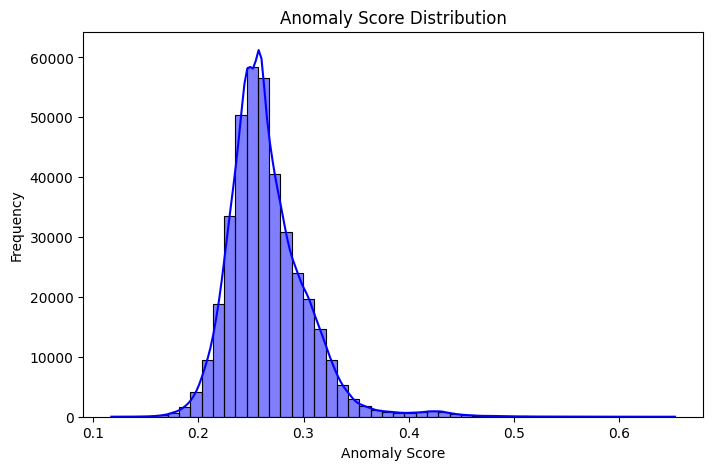

Anomaly Score Stats:
 - Min: 0.1171671562475775
 - Max: 0.6533612320949942
 - Mean: 0.2655249875926869
 - 95th Percentile: 0.32832527355016267


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 🟢 Step 1: Generate Reconstructed Output using Cortical Coding Model
X_val_reshaped = X_val[:X_val.size - (X_val.size % 7)].reshape(-1, 7)


# Reconstruct the validation dataset
reconstructed_X = network.reconstruct(X_val_reshaped)


# 🟢 Step 2: Compute Reconstruction Errors (Anomaly Scores)
anomaly_scores = np.linalg.norm(X_val_reshaped - reconstructed_X, axis=1)  # Euclidean distance

# 🟢 Step 3: Visualize Anomaly Score Distribution
plt.figure(figsize=(8, 5))
sns.histplot(anomaly_scores, bins=50, kde=True, color='blue')
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.title("Anomaly Score Distribution")
plt.show()

# 🟢 Step 4: Save Anomaly Scores for Further Processing
np.save("anomaly_scores.npy", anomaly_scores)  # Save scores for later use

# 🟢 Step 5: Print Summary Stats
print(f"Anomaly Score Stats:\n - Min: {np.min(anomaly_scores)}\n - Max: {np.max(anomaly_scores)}\n - Mean: {np.mean(anomaly_scores)}\n - 95th Percentile: {np.percentile(anomaly_scores, 95)}")


### Confusion Matrix

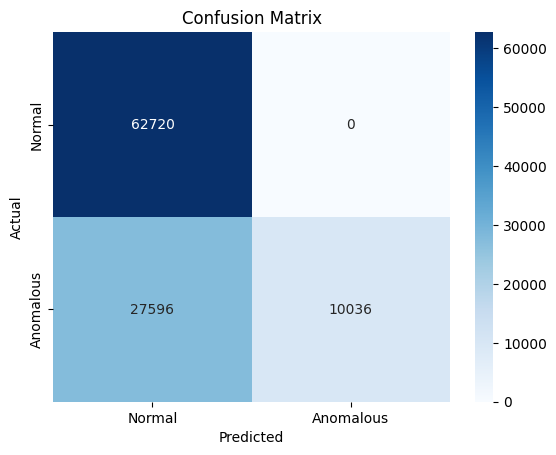

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomalous'], yticklabels=['Normal', 'Anomalous'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


### Anomaly Detection Threshold vs Recall / Precision Plot

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


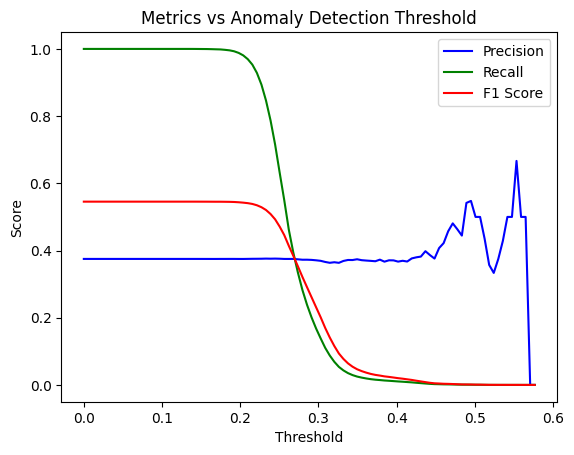

In [ ]:
anomaly_scores_downsampled = anomaly_scores[:len(y_true)]
thresholds = np.linspace(0, max(anomaly_scores_downsampled), 100)
precision = []
recall = []
f1 = []

for t in thresholds:
    pred = anomaly_scores_downsampled > t
    precision.append(precision_score(y_true, pred))
    recall.append(recall_score(y_true, pred))
    f1.append(f1_score(y_true, pred))

plt.plot(thresholds, precision, label='Precision', color='blue')
plt.plot(thresholds, recall, label='Recall', color='green')
plt.plot(thresholds, f1, label='F1 Score', color='red')
plt.title('Metrics vs Anomaly Detection Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()


### Precision Recall Curve

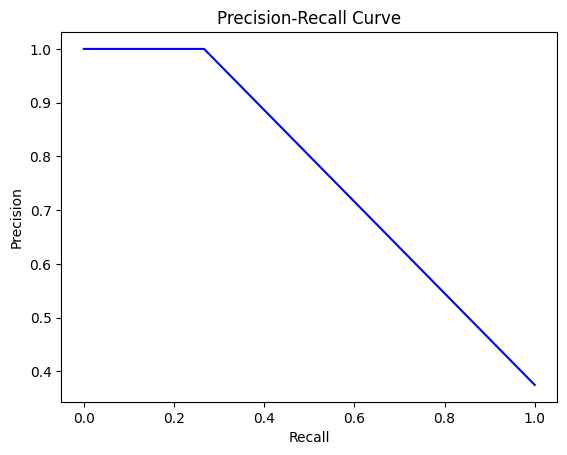

In [ ]:
from sklearn.metrics import precision_recall_curve

# Assuming you have `true_labels` and `predicted_scores` (reconstruction errors or anomaly scores)
precision_curve, recall_curve, thresholds = precision_recall_curve(y_true, y_pred)

plt.plot(recall_curve, precision_curve, color='blue')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()


### Combined Metrics

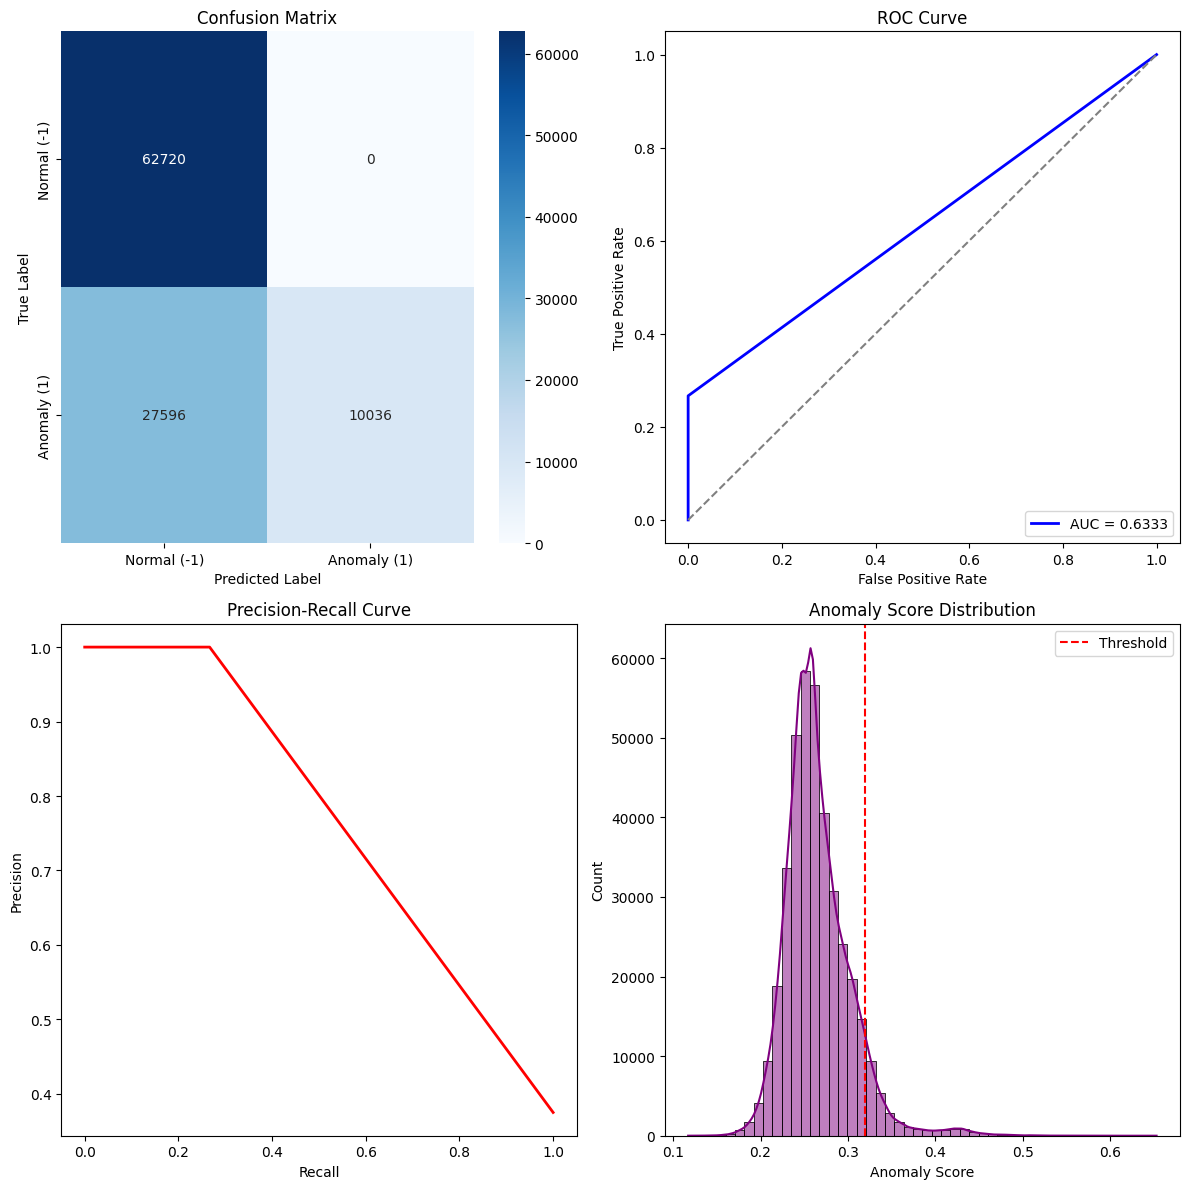

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, precision_recall_curve
)

def plot_metrics(true_labels, true_preds, anomaly_scores, threshold=0.32):
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))

    cm = confusion_matrix(y_true, y_pred)

    # 📌 1️⃣ Confusion Matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal (-1)', 'Anomaly (1)'],
                yticklabels=['Normal (-1)', 'Anomaly (1)'], ax=axes[0, 0])
    axes[0, 0].set_title("Confusion Matrix")
    axes[0, 0].set_xlabel("Predicted Label")
    axes[0, 0].set_ylabel("True Label")

    # 📌 2️⃣ ROC Curve
    fpr, tpr, _ = roc_curve(true_labels, true_preds)
    roc_auc = auc(fpr, tpr)
    axes[0, 1].plot(fpr, tpr, color="blue", lw=2, label=f"AUC = {roc_auc:.4f}")
    axes[0, 1].plot([0, 1], [0, 1], color="grey", linestyle="--")
    axes[0, 1].set_title("ROC Curve")
    axes[0, 1].set_xlabel("False Positive Rate")
    axes[0, 1].set_ylabel("True Positive Rate")
    axes[0, 1].legend(loc="lower right")

    # 📌 3️⃣ Precision-Recall Curve
    precisions, recalls, _ = precision_recall_curve(true_labels, true_preds)
    axes[1, 0].plot(recalls, precisions, color="red", lw=2)
    axes[1, 0].set_title("Precision-Recall Curve")
    axes[1, 0].set_xlabel("Recall")
    axes[1, 0].set_ylabel("Precision")

    # 📌 4️⃣ Anomaly Score Distribution
    sns.histplot(anomaly_scores, bins=50, kde=True, color="purple", ax=axes[1, 1])
    axes[1, 1].axvline(x=threshold, color="red", linestyle="--", label="Threshold")
    axes[1, 1].set_title("Anomaly Score Distribution")
    axes[1, 1].set_xlabel("Anomaly Score")
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()

# 🔥 Run the script with your anomaly scores
plot_metrics(y_true, y_pred, anomaly_scores)

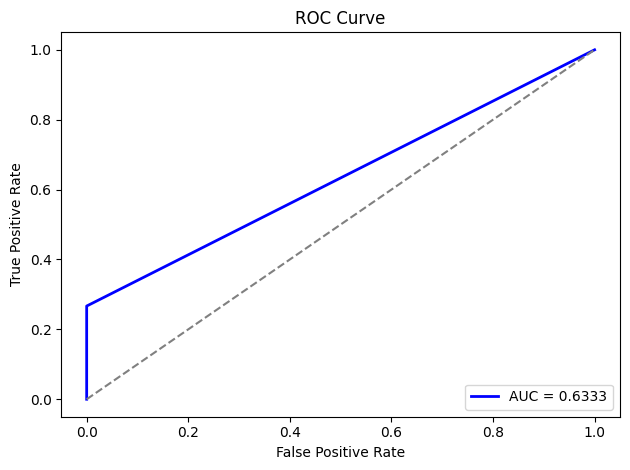

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, precision_recall_curve
)

def plot_metrics(true_labels, true_preds, anomaly_scores, threshold=0.32):
    fig, axes = plt.subplots(1, 1)

    # 📌 2️⃣ ROC Curve
    fpr, tpr, _ = roc_curve(true_labels, true_preds)
    roc_auc = auc(fpr, tpr)
    axes.plot(fpr, tpr, color="blue", lw=2, label=f"AUC = {roc_auc:.4f}")
    axes.plot([0, 1], [0, 1], color="grey", linestyle="--")
    axes.set_title("ROC Curve")
    axes.set_xlabel("False Positive Rate")
    axes.set_ylabel("True Positive Rate")
    axes.legend(loc="lower right")


    plt.tight_layout()
    plt.show()

# 🔥 Run the script with your anomaly scores
plot_metrics(y_true, y_pred, anomaly_scores)

### LSTM Autoencoders

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import precision_score, recall_score, f1_score
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from torch.utils.data import DataLoader, TensorDataset

# ---- Step 1: Extract Cortical Coding Features ----
def extract_cortical_features(network):
    cortical_values = [node.value.tolist() for node in network.nodes]
    spine_maturity = [spine.maturity_level for spine in network.spines]

    # Convert to numpy array for normalization
    cortical_values = np.array(cortical_values)
    spine_maturity = np.array(spine_maturity).reshape(-1, 1)  # Reshape for concatenation

    return cortical_values, spine_maturity


# ---- Step 2: Normalize and Prepare Time-Series Data ----
def preprocess_data(time_series_data, cortical_features, spine_features, use_standard_scaler=True):
    if use_standard_scaler:
      scaler = StandardScaler()
    else:
      scaler = MinMaxScaler()

    # Find the minimum number of rows available
    min_rows = min(len(time_series_data), len(cortical_features), len(spine_features))

    # Trim all datasets to match the smallest size
    time_series_data = time_series_data[:min_rows]
    cortical_features = cortical_features[:min_rows]
    spine_features = spine_features[:min_rows]

    # Ensure 1D arrays are reshaped to 2D
    if cortical_features.ndim == 1:
        cortical_features = cortical_features.reshape(-1, 1)
    if spine_features.ndim == 1:
        spine_features = spine_features.reshape(-1, 1)

    # Combine time-series with cortical and spine features
    combined_data = np.hstack((time_series_data, cortical_features, spine_features))
    normalized_data = scaler.fit_transform(combined_data)

    # Check the number of samples
    num_samples = normalized_data.shape[0]
    sequence_length = min(32, num_samples)  # Adjust sequence length dynamically

    if num_samples < sequence_length:
        print(
            f"Warning: Not enough samples to form the desired sequence length. Using sequence length: {sequence_length}"
        )
        # If there are not enough samples to form a sequence, return an empty array
        return np.array([]), scaler

    # Reshape to (num_samples, sequence_length, num_features)
    reshaped_data = normalized_data[: (num_samples // sequence_length) * sequence_length]
    reshaped_data = reshaped_data.reshape(-1, sequence_length, normalized_data.shape[1])

    # Ensure reshaped_data has 9 features (check input dimension)
    assert reshaped_data.shape[2] == 9, f"Expected 9 features, but got {reshaped_data.shape[2]} features."

    print("Shape of reshaped_data:", reshaped_data.shape)  # Debugging step

    return reshaped_data, scaler


class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=3, dropout=0.3):
        super(LSTMAutoencoder, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Encoder layers with batch normalization and dropout
        self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.encoder_bn = nn.BatchNorm1d(hidden_dim)  # Batchnorm on the hidden dimension

        # Decoder layers with batch normalization and dropout
        self.decoder = nn.LSTM(hidden_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.decoder_bn = nn.BatchNorm1d(hidden_dim)  # Batchnorm on the hidden dimension
        self.fc = nn.Linear(hidden_dim, input_dim)

    def reconstruct(self, x):
        batch_size, seq_length, _ = x.shape

        # Encoder
        encoded, (h, c) = self.encoder(x)
        encoded_permuted = encoded.permute(0, 2, 1)  # Reshape to (batch_size, hidden_dim, seq_length)
        encoded_bn = self.encoder_bn(encoded_permuted)  # Apply batchnorm on hidden dimension
        encoded = encoded_bn.permute(0, 2, 1)  # Reshape back to (batch_size, seq_length, hidden_dim)

        # Decoder
        decoder_input = torch.zeros(batch_size, seq_length, self.hidden_dim, device=x.device)
        decoded_seq, _ = self.decoder(decoder_input, (h, c))

        decoded_seq_permuted = decoded_seq.permute(0, 2, 1)  # Reshape to (batch_size, hidden_dim, seq_length)
        decoded_seq_bn = self.decoder_bn(decoded_seq_permuted)  # Apply batchnorm on hidden dimension
        decoded_seq = decoded_seq_bn.permute(0, 2, 1)  # Reshape back to (batch_size, seq_length, hidden_dim)

        x_reconstructed = self.fc(decoded_seq)

        return x_reconstructed


    def forward(self, x):
        batch_size, seq_length, _ = x.shape

        # Encoder
        encoded, (h, c) = self.encoder(x)
        encoded_permuted = encoded.permute(0, 2, 1)  # Reshape to (batch_size, hidden_dim, seq_length)
        encoded_bn = self.encoder_bn(encoded_permuted)  # Apply batchnorm on hidden dimension
        encoded = encoded_bn.permute(0, 2, 1)  # Reshape back to (batch_size, seq_length, hidden_dim)

        # Decoder
        decoder_input = torch.zeros(batch_size, seq_length, self.hidden_dim, device=x.device)
        decoded_seq, _ = self.decoder(decoder_input, (h, c))

        decoded_seq_permuted = decoded_seq.permute(0, 2, 1)  # Reshape to (batch_size, hidden_dim, seq_length)
        decoded_seq_bn = self.decoder_bn(decoded_seq_permuted)  # Apply batchnorm on hidden dimension
        decoded_seq = decoded_seq_bn.permute(0, 2, 1)  # Reshape back to (batch_size, seq_length, hidden_dim)

        x_reconstructed = self.fc(decoded_seq)
        return x_reconstructed

    # Custom loss function with higher penalty for larger errors
    def custom_loss(self, y_true, y_pred):
        mse = nn.MSELoss()(y_true, y_pred)
        # Larger penalty for bigger reconstruction errors (for anomaly detection)
        anomaly_penalty = torch.mean(torch.square(y_true - y_pred) * (y_true > 0.5).float())
        return mse + anomaly_penalty

    def train_model(self, train_data, epochs=300, batch_size=64, lr=0.0005, weight_decay=1e-5):
        optimizer = optim.AdamW(self.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = ReduceLROnPlateau(optimizer, "min", patience=10, verbose=True)

        train_tensor = torch.tensor(train_data, dtype=torch.float32)
        train_loader = DataLoader(TensorDataset(train_tensor), batch_size=batch_size, shuffle=True)

        train_loss_values = []

        for epoch in range(epochs):
            self.train()
            total_train_loss = 0
            for batch in train_loader:
                optimizer.zero_grad()
                x = batch[0]
                x_reconstructed = self(x)
                loss = self.custom_loss(x, x_reconstructed)
                loss.backward()

                # Gradient clipping to prevent exploding gradients
                torch.nn.utils.clip_grad_norm_(self.parameters(), 5.0)

                optimizer.step()
                total_train_loss += loss.item()

            avg_train_loss = total_train_loss / len(train_loader)
            train_loss_values.append(avg_train_loss)

            # Print training progress
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}")

            # Step the learning rate scheduler
            scheduler.step(avg_train_loss)

        return train_loss_values


    def validate_model(self, val_data, batch_size=64):
        # Set up loss function
        loss_fn = nn.MSELoss()

        val_tensor = torch.tensor(val_data, dtype=torch.float32)
        val_loader = DataLoader(TensorDataset(val_tensor), batch_size=batch_size, shuffle=False)

        val_loss_values = []
        val_precision_values = []
        val_recall_values = []
        val_accuracy_values = []
        val_f1_values = []
        anomaly_scores = []
        reconstruction_errors = []  # List to store reconstruction errors
        mse_scores = []  # List to store MSE scores

        self.eval()  # Set the model to evaluation mode

        total_val_loss = 0
        total_pred = []
        total_true = []

        with torch.no_grad():
            for batch in val_loader:
                x = batch[0]
                x_reconstructed = self(x)
                loss = loss_fn(x_reconstructed, x)
                total_val_loss += loss.item()

                # Get predictions and true labels (assuming binary classification for anomaly detection)
                pred = (x_reconstructed > 0.5).float()
                true = (x > 0.5).float()

                # Calculate anomaly scores based on reconstruction error
                anomaly_score = torch.mean(torch.abs(x - x_reconstructed), dim=(1, 2))  # Mean absolute error per sample
                anomaly_scores.append(anomaly_score.cpu().numpy())

                # Calculate reconstruction error (absolute error for each sample)
                reconstruction_error = torch.abs(x - x_reconstructed).mean(dim=(1, 2))  # Mean error per sample
                reconstruction_errors.append(reconstruction_error.cpu().numpy())

                # Calculate MSE for the reconstruction
                mse = torch.mean(torch.square(x - x_reconstructed), dim=(1, 2))  # Mean squared error per sample
                mse_scores.append(mse.cpu().numpy())

                total_pred.append(pred.cpu().numpy())
                total_true.append(true.cpu().numpy())

        avg_val_loss = total_val_loss / len(val_loader)
        val_loss_values.append(avg_val_loss)

        # Flatten for precision, recall, accuracy, and f1 score calculation
        total_pred = np.concatenate(total_pred, axis=0)
        total_true = np.concatenate(total_true, axis=0)

        precision = precision_score(total_true.flatten(), total_pred.flatten())
        recall = recall_score(total_true.flatten(), total_pred.flatten())
        accuracy = accuracy_score(total_true.flatten(), total_pred.flatten())
        f1 = f1_score(total_true.flatten(), total_pred.flatten())

        val_precision_values.append(precision)
        val_recall_values.append(recall)
        val_accuracy_values.append(accuracy)
        val_f1_values.append(f1)

        print(f"Validation Loss: {avg_val_loss:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")

        # Optionally, return anomaly scores, reconstruction errors, and mse scores
        anomaly_scores = np.concatenate(anomaly_scores, axis=0)
        reconstruction_errors = np.concatenate(reconstruction_errors, axis=0)
        mse_scores = np.concatenate(mse_scores, axis=0)

        return val_loss_values, val_precision_values, val_recall_values, val_accuracy_values, val_f1_values, anomaly_scores, reconstruction_errors, mse_scores




### LSTM Pre-Processing

In [ ]:
# Preprocess and train model
cortical_features, spine_features = extract_cortical_features(network)

# Assuming X_train and X_val are defined and contain your time-series data
data, scaler = preprocess_data(X_train, cortical_features, spine_features, use_standard_scaler=True)
val_data, _ = preprocess_data(X_val, cortical_features, spine_features, use_standard_scaler=True)

print(f"Data shape: {data.shape}")  # Check the data shape before passing to the model

Shape of reshaped_data: (6, 32, 9)
Shape of reshaped_data: (6, 32, 9)
Data shape: (6, 32, 9)


### LSTM Trianing

In [ ]:
import numpy as np
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Assuming `data` is your NumPy array, convert it to a PyTorch tensor
data_tensor = torch.tensor(data, dtype=torch.float32)

# Hyperparameter grid for LSTM
param_grid = {
    'epochs': [300, 500],
    'learning_rate': [0.001, 0.005],
    'batch_size': [32, 64],  # LSTM-specific
    'hidden_units': [64, 128],  # LSTM-specific
}

# Initialize variables to store the best model and performance
best_performance = float('inf')
best_params = None
lstm_model = None

# Track all errors for analysis
all_errors = []

# Iterate over the hyperparameter grid
for params in ParameterGrid(param_grid):
    print(f"Training with parameters: {params}")

    # Initialize your LSTM model with the parameters (replace with your LSTM model initialization)
    lstm_model = LSTMAutoencoder(input_dim=data.shape[2], hidden_dim=params['hidden_units'])

    # Train the lstm_model
    lstm_model.train_model(data_tensor, epochs=params['epochs'], batch_size=params['batch_size'], lr=params['learning_rate'])

    # Evaluate performance (e.g., using Mean Squared Error as a metric)
    predictions = lstm_model.reconstruct(data_tensor)  # Use your LSTM model's prediction method
    errors = np.abs(data_tensor.detach().numpy() - predictions.detach().numpy())  # Calculate absolute errors
    performance = np.mean(errors)  # Example performance metric: mean error

    # Track best performance
    if performance < best_performance:
        best_performance = performance
        best_params = params

    # Store all errors for further analysis
    all_errors.append(errors)

# Output the best model parameters and performance
print(f"Best parameters: {best_params}")
print(f"Best performance (Mean Absolute Error): {best_performance}")

# Concatenate all errors to flatten the array for easy analysis
all_errors = np.concatenate(all_errors, axis=0)

# Define a threshold for high errors (top 10% error samples)
error_threshold = np.percentile(all_errors, 90)  # Consider the top 10% error as high-error samples
high_error_indices = np.where(all_errors > error_threshold)[0]

# Display high-error samples
print(f"Number of high-error samples: {len(high_error_indices)}")
# for idx in high_error_indices[:5]:  # Display the top 5 high-error samples
#     print(f"Sample {idx}:")
#     print(f"Original: {data[idx]}")
#     print(f"Reconstructed: {predictions[idx]}")
#     print(f"Error: {all_errors[idx]}")
#     print("---")

Training with parameters: {'batch_size': 32, 'epochs': 300, 'hidden_units': 64, 'learning_rate': 0.001}


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-14-d1f51a94269f>:140: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_tensor = torch.tensor(train_data, dtype=torch.float32)


Streaming output truncated to the last 5000 lines.
Epoch 215/500, Train Loss: 0.9311
Epoch 216/500, Train Loss: 0.9200
Epoch 217/500, Train Loss: 0.9120
Epoch 218/500, Train Loss: 0.9106
Epoch 219/500, Train Loss: 0.9131
Epoch 220/500, Train Loss: 0.9110
Epoch 221/500, Train Loss: 0.8965
Epoch 222/500, Train Loss: 0.9103
Epoch 223/500, Train Loss: 0.9131
Epoch 224/500, Train Loss: 0.8993
Epoch 225/500, Train Loss: 0.8908
Epoch 226/500, Train Loss: 0.8787
Epoch 227/500, Train Loss: 0.8866
Epoch 228/500, Train Loss: 0.8745
Epoch 229/500, Train Loss: 0.8676
Epoch 230/500, Train Loss: 0.8775
Epoch 231/500, Train Loss: 0.8640
Epoch 232/500, Train Loss: 0.8560
Epoch 233/500, Train Loss: 0.8609
Epoch 234/500, Train Loss: 0.8420
Epoch 235/500, Train Loss: 0.8376
Epoch 236/500, Train Loss: 0.8376
Epoch 237/500, Train Loss: 0.8467
Epoch 238/500, Train Loss: 0.8292
Epoch 239/500, Train Loss: 0.8531
Epoch 240/500, Train Loss: 0.8478
Epoch 241/500, Train Loss: 0.8324
Epoch 242/500, Train Loss: 0.82

### Validate LSTM Model

In [ ]:
# Now, validate the model
val_loss_values, val_precision_values, val_recall_values, val_accuracy_values, val_f1_values, anomaly_scores, reconstruction_errors, mse_scores = lstm_model.validate_model(val_data)


# For MSE values
avg_mse = np.mean(mse_scores)
max_mse = np.max(mse_scores)
min_mse = np.min(mse_scores)

print("\n📊 Model Performance Metrics:")
print(f"✅ Average MSE: {avg_mse:.4f}")
print(f"✅ Max MSE: {max_mse:.4f}")
print(f"✅ Min MSE: {min_mse:.4f}")
print(f"✅ Accuracy: {val_accuracy_values}")
print(f"✅ Precision: {val_precision_values}")
print(f"✅ Recall: {val_recall_values}")
print(f"✅ F1 Score: {val_f1_values}")


Validation Loss: 0.4806, Precision: 0.6649, Recall: 0.6578, Accuracy: 0.8530, F1 Score: 0.6613

📊 Model Performance Metrics:
✅ Average MSE: 0.4806
✅ Max MSE: 0.5561
✅ Min MSE: 0.3888
✅ Accuracy: [0.8530092592592593]
✅ Precision: [0.6648793565683646]
✅ Recall: [0.6578249336870027]
✅ F1 Score: [0.6613333333333333]


### Anamoly Score Distribution

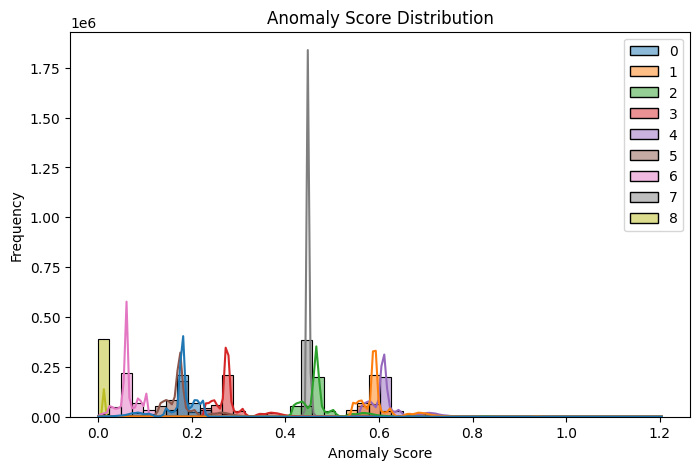

Anomaly Score Stats:
 - Min: 0.378618448972702
 - Max: 0.46675512194633484
 - Mean: 0.41582122445106506
 - 95th Percentile: 0.46548794209957123


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 🟢 Step 1: Generate Reconstructed Output using Cortical Coding Model
X_val_lstm_reshaped = X_val[:X_val.size - (X_val.size % 7)].reshape(-1, 7)

X_val_lstm_reshaped = torch.tensor(X_val_lstm_reshaped, dtype=torch.float32)

expected_feature_size = 9
current_feature_size = X_val_lstm_reshaped.shape[-1]

# If feature size is smaller than expected, pad with zeros
if current_feature_size < expected_feature_size:
    padding_size = expected_feature_size - current_feature_size
    padding = torch.zeros(X_val_lstm_reshaped.shape[0], padding_size)
    X_val_lstm_reshaped = torch.cat((X_val_lstm_reshaped, padding), dim=-1)

if len(X_val_lstm_reshaped.shape) == 2:
    X_val_lstm_reshaped = X_val_lstm_reshaped.unsqueeze(1)

# Reconstruct the validation dataset
reconstructed_lstm_X = lstm_model.reconstruct(X_val_lstm_reshaped)


# 🟢 Step 2: Compute Reconstruction Errors (Anomaly Scores)
anomaly_scores_lstm = np.linalg.norm(X_val_lstm_reshaped.detach().numpy() - reconstructed_lstm_X.detach().numpy(), axis=1)  # Euclidean distance

# 🟢 Step 3: Visualize Anomaly Score Distribution
plt.figure(figsize=(8, 5))
sns.histplot(anomaly_scores_lstm, bins=50, kde=True, color='blue')
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.title("Anomaly Score Distribution")
plt.show()

# 🟢 Step 4: Save Anomaly Scores for Further Processing
np.save("anomaly_scores_lstm.npy", anomaly_scores)  # Save scores for later use

# 🟢 Step 5: Print Summary Stats
print(f"Anomaly Score Stats:\n - Min: {np.min(anomaly_scores)}\n - Max: {np.max(anomaly_scores)}\n - Mean: {np.mean(anomaly_scores)}\n - 95th Percentile: {np.percentile(anomaly_scores, 95)}")


### Confusiom Matrix

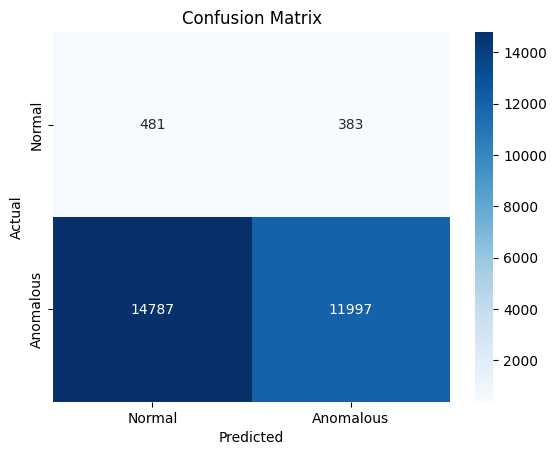

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Example threshold for classifying anomalies
threshold = 0.4  # You can adjust this based on your findings

# Convert anomaly scores into binary labels (Normal: 0, Anomalous: 1)
y_pred_lstm = (anomaly_scores_lstm > threshold).astype(int)

# Assign labels: 1 for high-error (anomalous), 0 for normal
y_true_lstm = np.zeros_like(all_errors, dtype=int)
y_true_lstm[high_error_indices] = 1  # Mark high-error samples as anomalies

# Ensure y_true and y_pred are 1D arrays
y_true_lstm = y_true_lstm.ravel()
y_pred_lstm = y_pred_lstm.ravel()

y_pred_lstm = y_pred_lstm[:len(y_true_lstm)]

# Generate the confusion matrix
cm = confusion_matrix(y_true_lstm, y_pred_lstm)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomalous'], yticklabels=['Normal', 'Anomalous'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


### Combined Metrics

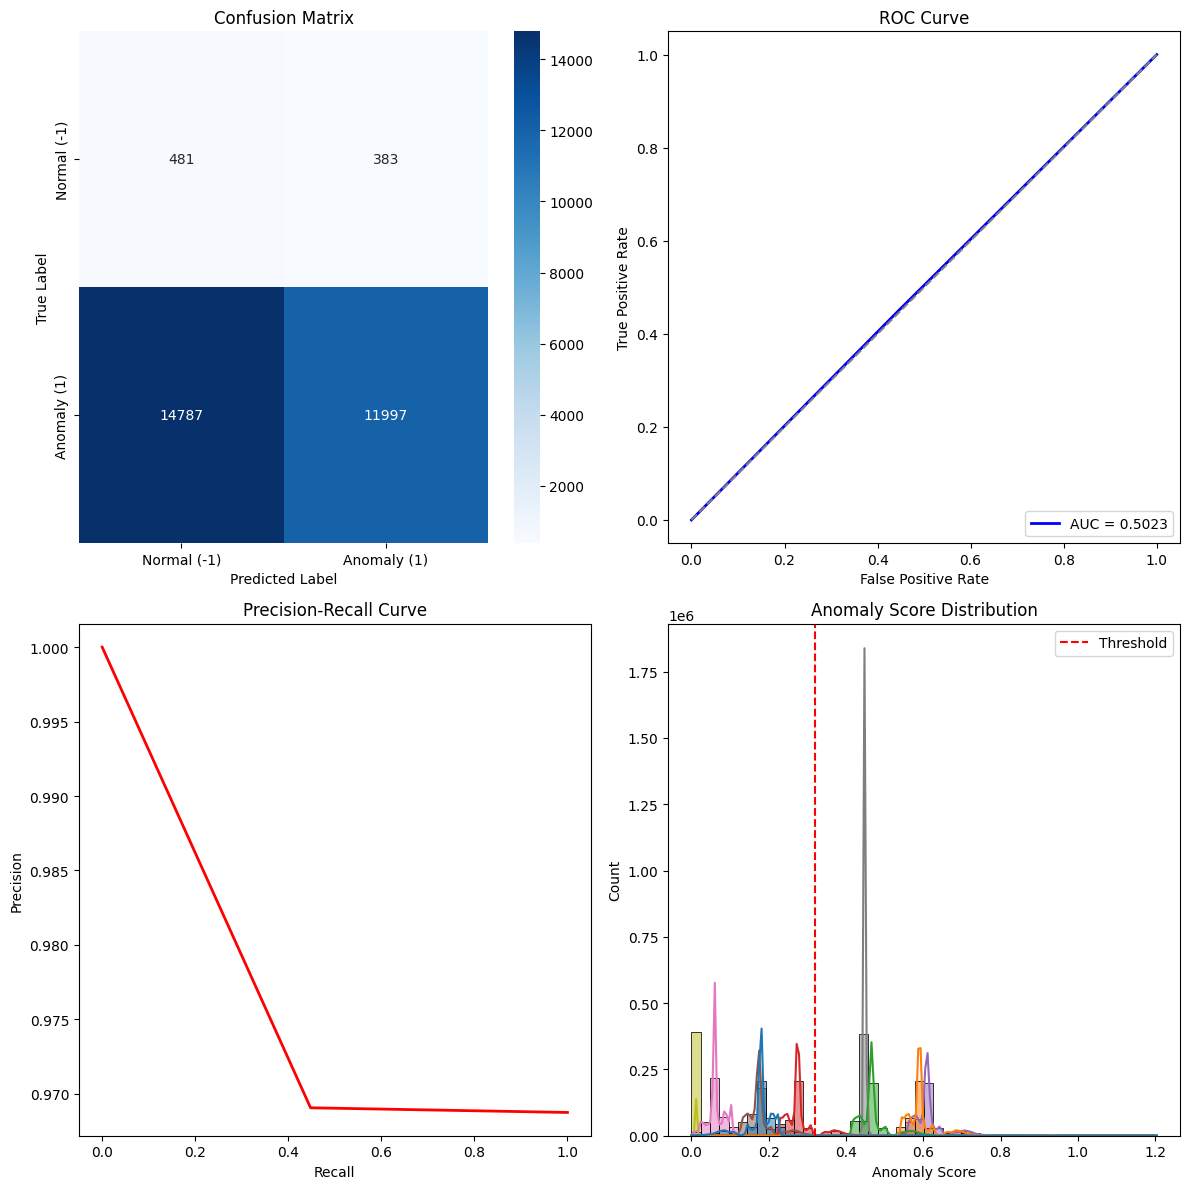

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, precision_recall_curve
)

def plot_metrics(true_labels, true_preds, anomaly_scores, threshold=0.32):
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))

    cm = confusion_matrix(true_labels, true_preds)

    # 📌 1️⃣ Confusion Matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal (-1)', 'Anomaly (1)'],
                yticklabels=['Normal (-1)', 'Anomaly (1)'], ax=axes[0, 0])
    axes[0, 0].set_title("Confusion Matrix")
    axes[0, 0].set_xlabel("Predicted Label")
    axes[0, 0].set_ylabel("True Label")

    # 📌 2️⃣ ROC Curve
    fpr, tpr, _ = roc_curve(true_labels, true_preds)
    roc_auc = auc(fpr, tpr)
    axes[0, 1].plot(fpr, tpr, color="blue", lw=2, label=f"AUC = {roc_auc:.4f}")
    axes[0, 1].plot([0, 1], [0, 1], color="grey", linestyle="--")
    axes[0, 1].set_title("ROC Curve")
    axes[0, 1].set_xlabel("False Positive Rate")
    axes[0, 1].set_ylabel("True Positive Rate")
    axes[0, 1].legend(loc="lower right")

    # 📌 3️⃣ Precision-Recall Curve
    precisions, recalls, _ = precision_recall_curve(true_labels, true_preds)
    axes[1, 0].plot(recalls, precisions, color="red", lw=2)
    axes[1, 0].set_title("Precision-Recall Curve")
    axes[1, 0].set_xlabel("Recall")
    axes[1, 0].set_ylabel("Precision")

    # 📌 4️⃣ Anomaly Score Distribution
    sns.histplot(anomaly_scores, bins=50, kde=True, color="purple", ax=axes[1, 1])
    axes[1, 1].axvline(x=threshold, color="red", linestyle="--", label="Threshold")
    axes[1, 1].set_title("Anomaly Score Distribution")
    axes[1, 1].set_xlabel("Anomaly Score")
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()

# 🔥 Run the script with your anomaly scores
plot_metrics(y_true_lstm, y_pred_lstm, anomaly_scores_lstm)

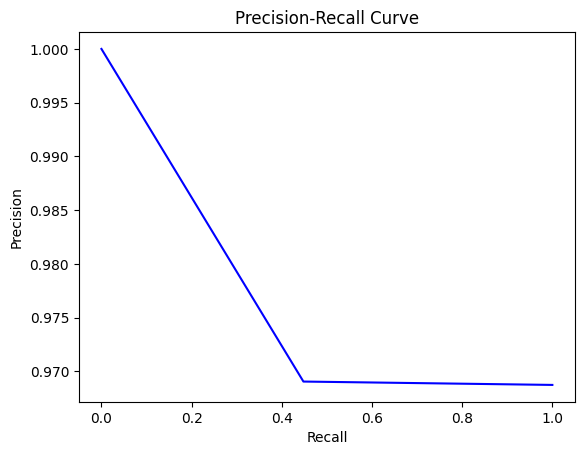

In [ ]:
from sklearn.metrics import precision_recall_curve

# Assuming you have `true_labels` and `predicted_scores` (reconstruction errors or anomaly scores)
precision_curve, recall_curve, thresholds = precision_recall_curve(y_true_lstm, y_pred_lstm)

plt.plot(recall_curve, precision_curve, color='blue')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()


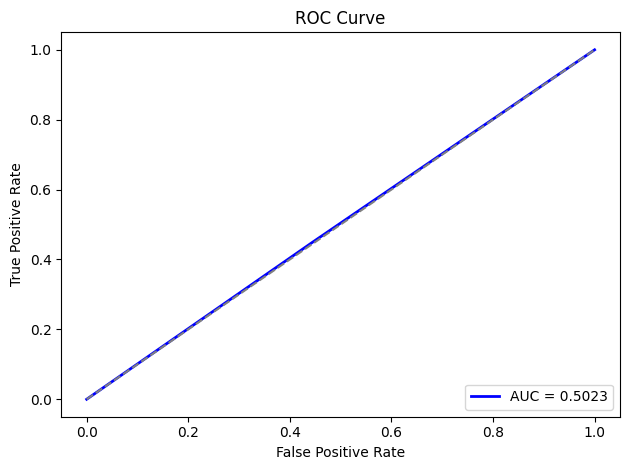

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, precision_recall_curve
)

def plot_metrics(true_labels, true_preds, anomaly_scores, threshold=0.32):
    fig, axes = plt.subplots(1, 1)

    # 📌 2️⃣ ROC Curve
    fpr, tpr, _ = roc_curve(true_labels, true_preds)
    roc_auc = auc(fpr, tpr)
    axes.plot(fpr, tpr, color="blue", lw=2, label=f"AUC = {roc_auc:.4f}")
    axes.plot([0, 1], [0, 1], color="grey", linestyle="--")
    axes.set_title("ROC Curve")
    axes.set_xlabel("False Positive Rate")
    axes.set_ylabel("True Positive Rate")
    axes.legend(loc="lower right")


    plt.tight_layout()
    plt.show()

# 🔥 Run the script with your anomaly scores
plot_metrics(y_true_lstm, y_pred_lstm, anomaly_scores_lstm)

### Metrics vs Anamoly Detection

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.p

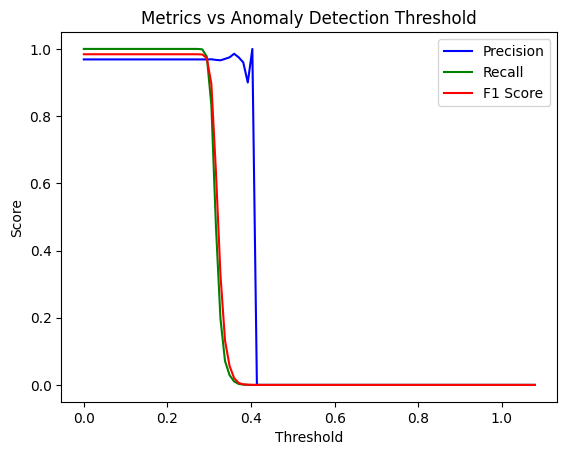

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming anomaly_scores_lstm and y_true_lstm are already defined

# Ensure the lengths match (downsample anomaly_scores_lstm if necessary)
anomaly_scores_lstm_downsampled = anomaly_scores_lstm[:len(y_true_lstm)]

# If y_true_lstm is a multilabel indicator (i.e., one-hot encoded), flatten it to binary format
if y_true_lstm.ndim > 1:
    y_true_lstm = np.max(y_true_lstm, axis=1)

# Now we have two arrays:
# - anomaly_scores_lstm_downsampled
# - y_true_lstm (both should be 1D arrays of length N)

# Create a range of thresholds to evaluate
thresholds = np.linspace(0, np.max(anomaly_scores_lstm_downsampled), 100)

# Initialize lists to store precision, recall, and F1 scores
precision = []
recall = []
f1 = []

# Calculate the metrics for each threshold
for t in thresholds:
    # Convert anomaly scores to binary predictions based on the threshold
    # Ensure anomaly_scores_lstm_downsampled is averaged to a single score before applying the threshold
    pred = (np.mean(anomaly_scores_lstm_downsampled, axis=1) > t).astype(int)

    # Calculate precision, recall, and F1 scores for the given threshold
    precision.append(precision_score(y_true_lstm, pred))
    recall.append(recall_score(y_true_lstm, pred))
    f1.append(f1_score(y_true_lstm, pred))

# Plot the metrics
plt.plot(thresholds, precision, label='Precision', color='blue')
plt.plot(thresholds, recall, label='Recall', color='green')
plt.plot(thresholds, f1, label='F1 Score', color='red')
plt.title('Metrics vs Anomaly Detection Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()

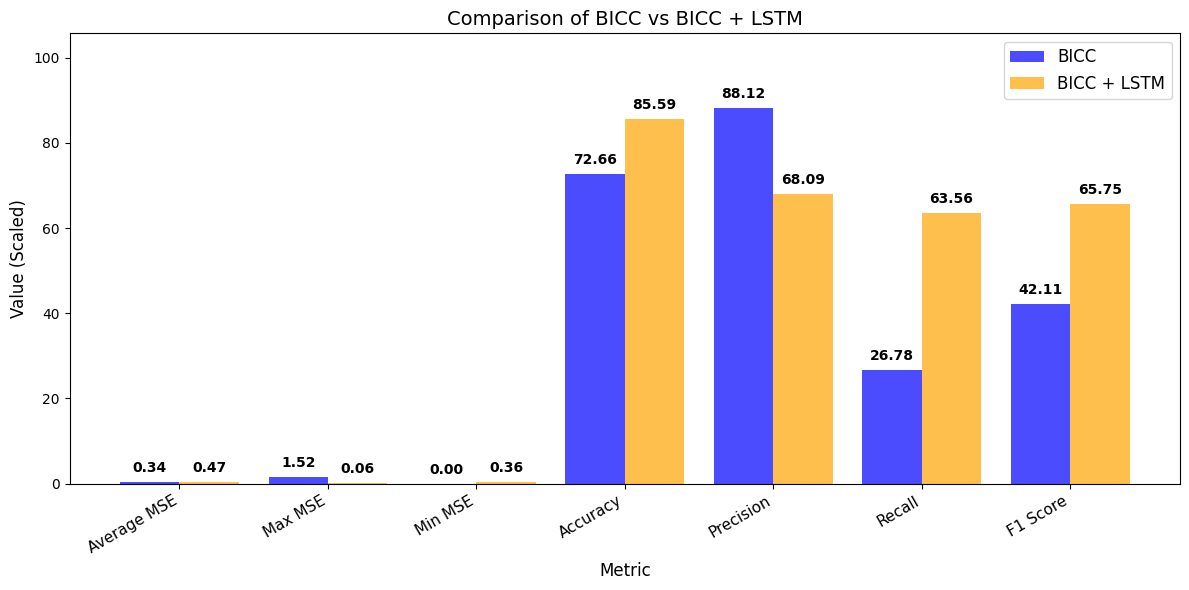

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Data
metrics = ["Average MSE", "Max MSE", "Min MSE", "Accuracy", "Precision", "Recall", "F1 Score"]
bicc_values = [0.3397, 15.1988, 0.0008, 72.66, 88.12, 26.78, 42.11]
bicc_lstm_values = [0.4749, 0.6245, 0.3577, 85.59, 68.09, 63.56, 65.75]

# Normalize large values to bring them in a comparable range
scaling_factors = [1, 0.1, 1, 1, 1, 1, 1]  # Scale Max MSE down for better visualization
bicc_values = [bicc_values[i] * scaling_factors[i] for i in range(len(metrics))]
bicc_lstm_values = [bicc_lstm_values[i] * scaling_factors[i] for i in range(len(metrics))]

# Bar chart parameters
x = np.arange(len(metrics))
width = 0.4  # Bar width

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, bicc_values, width, label="BICC", color="blue", alpha=0.7)
bars2 = ax.bar(x + width/2, bicc_lstm_values, width, label="BICC + LSTM", color="orange", alpha=0.7)

# Labels and formatting
ax.set_xlabel("Metric", fontsize=12)
ax.set_ylabel("Value (Scaled)", fontsize=12)
ax.set_title("Comparison of BICC vs BICC + LSTM", fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=30, ha="right", fontsize=11)
ax.legend(fontsize=12)

# Set Y-axis limit for better visibility
ax.set_ylim([0, max(max(bicc_values), max(bicc_lstm_values)) * 1.2])

# Annotate bars with values
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f"{height:.2f}",
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5),  # Offset text slightly above bars
                    textcoords="offset points",
                    ha="center", va="bottom", fontsize=10, fontweight="bold")

# Show plot
plt.tight_layout()
plt.show()
